---

# Doug and the Data Diggers

Authors: Jakub Rybicki, Chris O'Malley, Doug Mill

---

## Overview

Our task is to build an inferential linear regression model. Our model will help our stakeholder understand King County home valuations better. We will follow the assumptions of linear regression which are linearity, independence, normality, and homoscedasticity. We will also strive to have a high R^2 value, signaling that our parameters are explaining much of the total variance in house sales.

## Business Understanding

Our stakeholder is an out-of-town real estate agency interested in opening an office in King County. The county seat is Seattle.

We are acting as a consultant for our stakeholder to determine key factors in evaluating a home in King County. We want to provide our client with the math and reasoning behind local home valuations. We will discuss the important features that affect a valuation based on analysis of previous home sales in the area. We will take a look at factors such as home size & space, school district in which the home is located, upgrades & amenities, and local market conditions.

Our stakeholder will be able to evaluate the Seattle and King County real estate market by understanding the key variables that affect price from our analysis.

## Data Understanding

Our original data set includes info about King County homes that sold between May 2nd, 2014 to May 24th, 2015. The target variable is price. We removed properties that were outside of three standard deviations of the mean price. This left us with homes with a price under $1.65M. We also removed typos. That took us from 21597 entries to 21280. We then incorporated 2015 School GIS data from kingcounty.gov in order to create our 'District' variable. The District variable includes the school district that the home is located in. There are 18 school districts in King County. We cleaned the original data set and merged it with the outside data in order to create our cleaned dataset, known as 'KingSchool.csv'. It can be found in the data folder.

### *Loading our data*

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.power import TTestIndPower, TTestPower
import matplotlib.pyplot as plt
%matplotlib inline
import math
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate, ShuffleSplit
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, median_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyRegressor
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from statsmodels.stats.outliers_influence import variance_inflation_factor

## Data Preparation

For data preparation, we formatted many columns. We later decided we didn't need to use many of them. We ended up eliminating samples where the price was outside of 3 standard deviations of the mean price. We then found a typo and removed it. This is how we cleaned the data from the dataset that was included which was kc_house_data.csv. 

We incorporated 2015 School GIS data from the kingcounty.gov website. We then merged it with kc_house_data.csv on 4 different keys; 'id', 'lat', 'long', and 'zipcode'. This plotted the entries against district lines, and formed a column in which each entry was classified by the district that it was located in. There are 18 school districts in King County; Mercer Island, Bellevue, Seattle, Lake Washington, Vashon Island, Issaquah, Shoreline, Northshore, Snoqualmie Valley, Riverview, Highline, Renton, Skykomish, Enumclaw, Tahoma, Tukwila, Kent, and Federal Way.

Since district contained 18 categories, we changed it into dummy variables. By using get_dummies, District was transformed into 18 seperate variables. Each variable contains a 0 or 1. 0 signals that the house was not located in that district while 1 signals that it is present in that district.

We picked which columns that we wanted to focus on originally from a heatmap of correlations. We ran train test splits for every single model that we did. We also made sure to run StandardScaler on every single model we did in order to scale them.

In [2]:
df  = pd.read_csv('data/KingSchool.csv')

In [3]:
categoricals = ['District']
dummies = pd.get_dummies(df[categoricals], prefix=categoricals, drop_first=True)
df = df.drop(categoricals, axis=1)
df = pd.concat([df, dummies], axis=1)

In [4]:
df.drop(['date'],axis=1,inplace=True)
df = df.astype(np.float64)
df['District_FEDERAL_WAY'] = df['District_FEDERAL WAY']
df['District_LAKE_WASHINGTON'] = df['District_LAKE WASHINGTON']
df['District_MERCER_ISLAND'] = df['District_MERCER ISLAND']
df['District_SNOQUALMIE_VALLEY'] = df['District_SNOQUALMIE VALLEY']
df['District_VASHON_ISLAND'] = df['District_VASHON ISLAND']
df.drop(['District_FEDERAL WAY','District_LAKE WASHINGTON','District_MERCER ISLAND',
                         'District_SNOQUALMIE VALLEY','District_VASHON ISLAND'],axis=1,inplace=True)

In [5]:
df_dummies = ['District_BELLEVUE','District_ENUMCLAW','District_FEDERAL_WAY','District_HIGHLINE',
                         'District_ISSAQUAH','District_KENT','District_LAKE_WASHINGTON','District_MERCER_ISLAND',
                         'District_NORTHSHORE','District_RENTON','District_RIVERVIEW','District_SEATTLE',
                         'District_SHORELINE','District_SKYKOMISH','District_SNOQUALMIE_VALLEY','District_TAHOMA',
                         'District_TUKWILA','District_VASHON_ISLAND']

## Modeling

We created 6 models using Baseline formula, First formula, Good formula, Great formula, Awesome formula, and Amazing formula.
In the end, we decided to go with Great formula for our Final Model. 

Our Final model has the follow predictors:
1. Square feet living
2. School Districts
3. Building Grade

We decided our final model is adequate with an R-squared value of .72 with only 3 predictors. The simplicity of it makes it easy to understand and use while also explaining such a high amount of the variance in price.

To run our models, we have written Helper Functions. 
Our 'linearity_plot' function is checking for the linearity assumption in the input.
Our 'model_and_assume' function creates a model and returns OLS results, RMSE, and checks assumptions with each formula input.

### *Helper Functions*

In [6]:
def linearity_plot(x, y):
    x = pd.DataFrame(x)
    y = pd.DataFrame(y)
    ok_list = ['sqft_living', 'view', 'grade', 'yr_built']
    our_list = []
    for col in x.columns:
        if col in ok_list:
            our_list.append(col)
    x = x[our_list]
    cols = 1
    if x.shape[1] % 2 == 0:
        cols = 2
    elif x.shape[1] < 2:
        cols = 1
    else:
        cols = 3
    rows = 1
    if x.shape[1] // cols == 0:
        rows = 1
    elif x.shape[1] % cols > 0:
        rows = x.shape[1] // cols + 1
    else:
        rows = rows = x.shape[1] // cols    
    
    fig, axes = plt.subplots(ncols=cols, nrows=rows, figsize=(12, 7), squeeze=False)
    fig.set_tight_layout(True)
    for index, col in enumerate(x.columns):
        ax = axes[index//cols][index%cols]
        ax.scatter(x[col], y, alpha=0.2)
        ax.set_xlabel(col, fontsize=15)
        ax.set_ylabel("Listing price", fontsize=15)
    fig.suptitle('LINEAR ASSUMPTIONS', fontsize=30)

In [7]:
def model_and_assume(formula = df.columns[2:], base=False, final=False):
    y = df['price']
    X = df[formula]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    if base:        
        model = DummyRegressor(strategy="mean")
    else:
        model = LinearRegression()

    # Fit the model on X_train and y_train
    model.fit(X_train_scaled, y_train)

    # Score the model on X_test and y_test
    # (use the built-in .score method)
    model_score = model.score(X_test_scaled, y_test)       
    print(f'Model Score: {model_score}')
    
    #For dummy regression
    if base:
        print(f'Train Mean: {y_train.mean()}, Test Mean: {y_test.mean()}')        
    else:       
        print(f'Train RMSE: {mean_squared_error(y_train, model.predict(X_train_scaled), squared=False)}')
        print(f'Test RMSE: {mean_squared_error(y_test, model.predict(X_test_scaled), squared=False)}')

        print('\n\n', sm.OLS(y_train, sm.add_constant(X_train)).fit().summary())
    
    #If More than OLS Needed
    if final == False: 
        X_train_scaled = pd.DataFrame(X_train_scaled)
        X_train_scaled.columns = X.columns
        X_test_scaled = pd.DataFrame(X_test_scaled)
        X_test_scaled.columns = X.columns

        #Checking MULTICOLLINEARITY 
        #(VIF NEEDS TO BE <5 ALL CATEGORIES)
        print(X_train_scaled.shape)

        if X_train_scaled.shape[1] > 1:
            vif = [variance_inflation_factor(X_train_scaled.values, i) for i in range(X_train_scaled.shape[1])]
            print('\nVIF')
            print(pd.Series(vif, index=X_train_scaled.columns, name="Variance Inflation Factor"), '\n\n')

        #Residuals
        preds = model.predict(X_test_scaled)
        residuals = (y_test - preds)

        #Linearity
        linearity_plot(X_train, y_train)

        fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,7))
        fig.set_tight_layout(True)

        #Normality
        sm.graphics.qqplot(residuals, dist=stats.norm, line='r', fit=True, ax=ax1)
        ax1.set_xlabel("Theoretical Quantiles", fontsize=15)
        ax1.set_ylabel("Sample Quantiles", fontsize=15);

        #HOMOSCEDASTICITY
        ax2.scatter(preds, residuals, alpha=0.5)
        ax2.plot(preds, [0 for i in range(len(X_test_scaled))], color='black')
        ax2.set_xlabel("Predicted Value", fontsize=15)
        ax2.set_ylabel("Actual - Predicted Value", fontsize=15);
        plt.show();
    
    

### Baseline Model

Our baseline model uses the mean price of the whole dataset. It is a horizontal line which sits at the mean price.

Model Score: -5.9275367333189166e-05
Train Mean: 505470.75820802007, Test Mean: 503495.4421052632
(15960, 41)

VIF
price                           4.620455
bedrooms                        1.773810
bathrooms                       3.290425
sqft_living                   136.974521
sqft_lot                        2.248188
floors                          2.335507
waterfront                      1.158956
view                            1.380551
condition                       1.282061
grade                           3.719386
sqft_above                    116.054328
sqft_basement                  37.288304
yr_built                        2.826651
yr_renovated                    1.367759
zipcode                         4.742796
lat                            10.114676
long                            9.717794
sqft_living15                   3.221270
sqft_lot15                      2.400159
renovated_less_10yrs            1.253284
has_basement                    3.743309
Distance_to_School_ft   

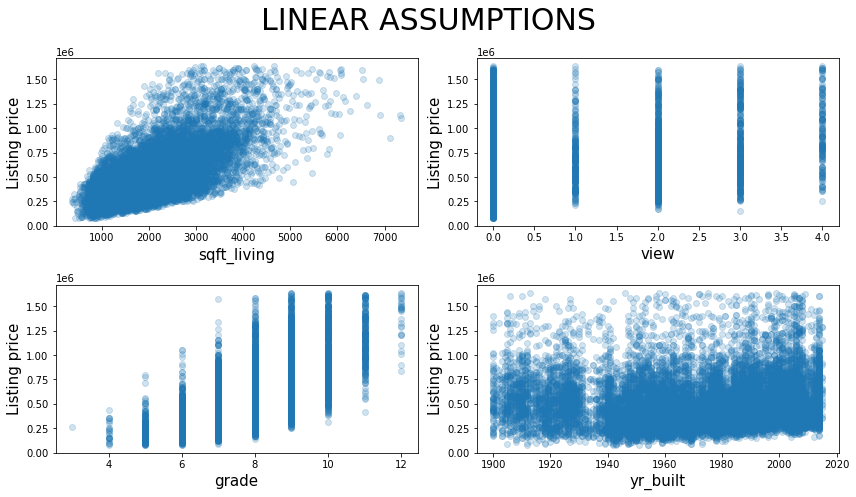

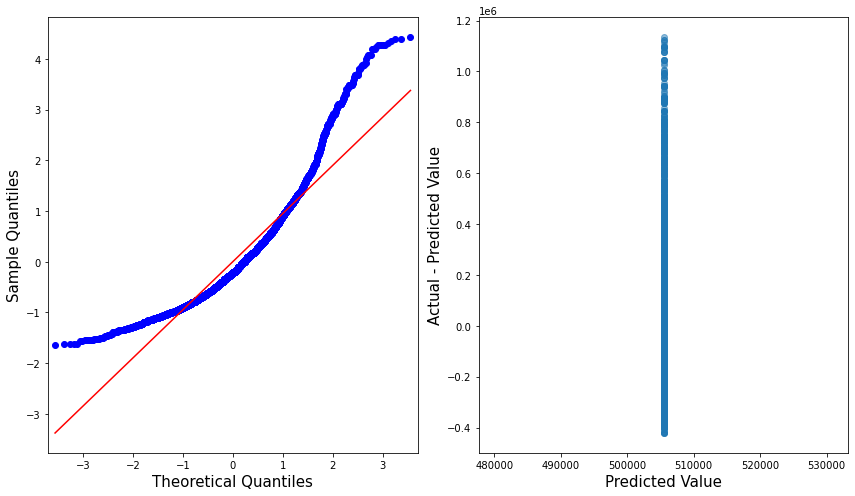

In [8]:
model_and_assume(base=True)

### *Interpreting the baseline model*

Our baseline model definitely follows the linearity assumption. The distribution of errors is slightly skewed right. Many of the VIF values are above 10 and this indicates that there is high multicollinearity. It passes the homoscedasticity test.

### *Dropping Unnecessary Columns*

In [9]:
df.drop(['id','bedrooms','bathrooms','sqft_lot','floors','waterfront','condition','sqft_above','sqft_basement', 'yr_renovated',
                         'zipcode','lat','long','sqft_living15','sqft_lot15','renovated_less_10yrs',
                         'has_basement','Distance_to_School_ft','mean_price'], axis=1,inplace=True)

### First Model: Square Feet Living & Price

Our first model includes Square Feet Living plotted against Price.

Model Score: 0.44356328845218684
Train RMSE: 193820.19648495235
Test RMSE: 191384.76568586275


                             OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.445
Model:                            OLS   Adj. R-squared:                  0.445
Method:                 Least Squares   F-statistic:                 1.281e+04
Date:                Tue, 12 Oct 2021   Prob (F-statistic):               0.00
Time:                        23:01:43   Log-Likelihood:            -2.1695e+05
No. Observations:               15960   AIC:                         4.339e+05
Df Residuals:                   15958   BIC:                         4.339e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------

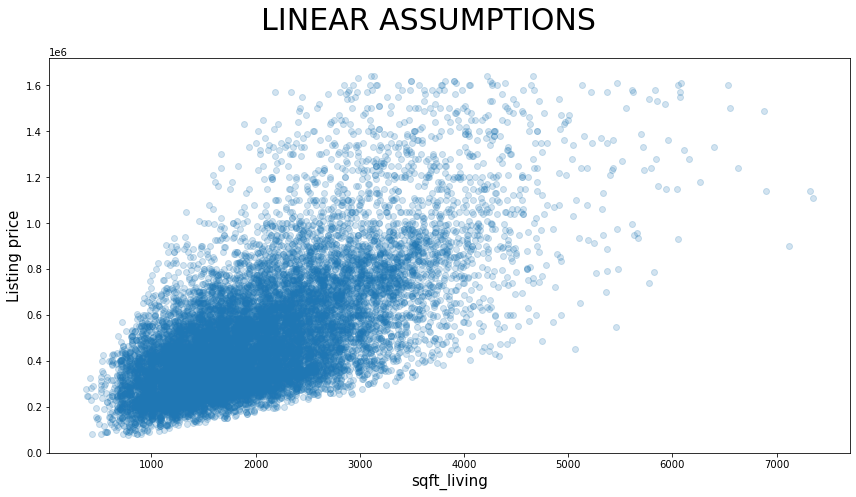

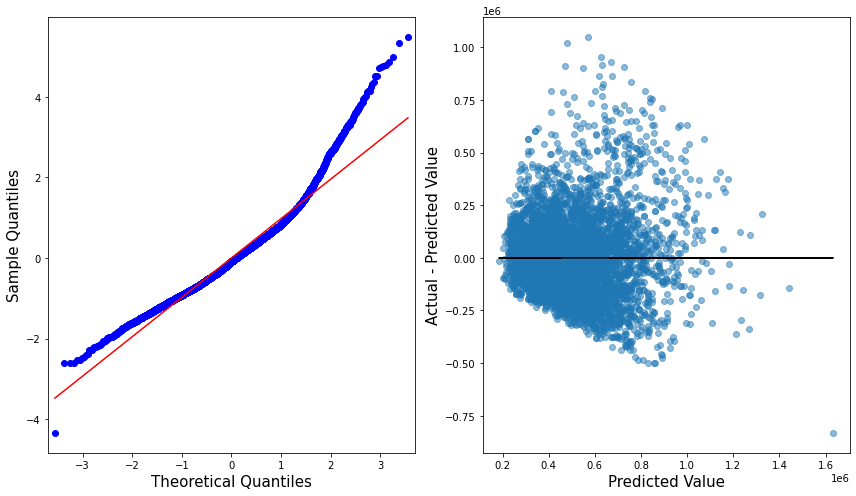

In [10]:
first_formula = ['sqft_living']
model_and_assume(first_formula)

### *Interpreting the first model*

Square Feet Living drives up Price. It has an R-squared of .445. It explains 44.5% of the variance in price by itself. It is the most correlated variable and individually most significant in our findings. Our first model definitely follows the linearity assumption. The distribution of errors is very slightly heavy on the tails. Multicollinearity is not applicable for one predictor. It passes the homoscedasticity test.

### Good Model: Square Feet Living and School District

For the good model, we have 2 predictors. Those predictors are square feet living and school district. Our school district variable consists of the 18 districts located in King County. Those districts are Bellevue, Enumclaw, Federal Way, Highline, Issaquah, Kent, Lake Washington, Mercer Island, Northshore, Renton, Riverview, Seattle, Shoreline, Skykomish, Snoqualmie Valley, Tahoma, Tukwila, Vashon Island.

Model Score: 0.6820648160650273
Train RMSE: 146504.89668165264
Test RMSE: 144666.7659178019


                             OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.683
Model:                            OLS   Adj. R-squared:                  0.683
Method:                 Least Squares   F-statistic:                     1808.
Date:                Tue, 12 Oct 2021   Prob (F-statistic):               0.00
Time:                        23:01:44   Log-Likelihood:            -2.1249e+05
No. Observations:               15960   AIC:                         4.250e+05
Df Residuals:                   15940   BIC:                         4.252e+05
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------

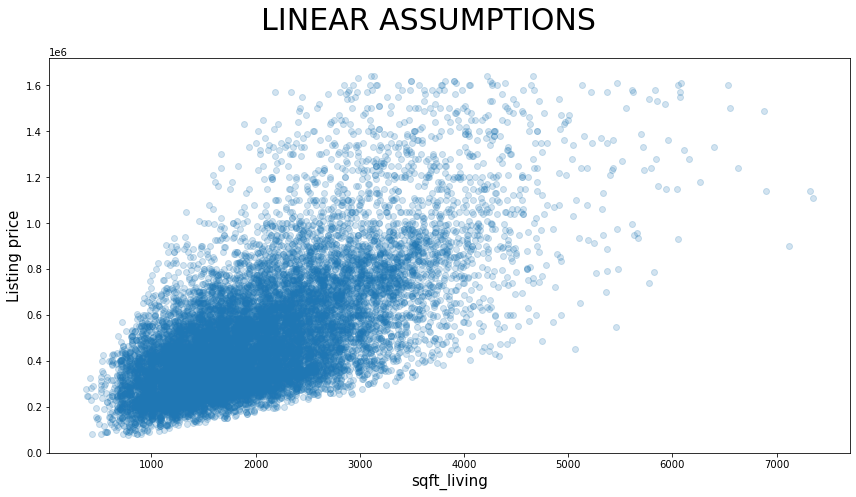

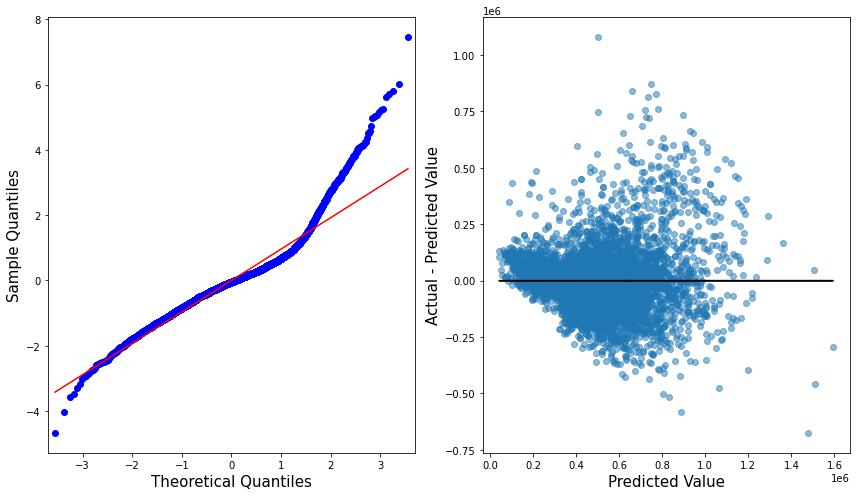

In [11]:
good_formula = first_formula + ['District_BELLEVUE','District_ENUMCLAW','District_FEDERAL_WAY',
                 'District_HIGHLINE','District_ISSAQUAH','District_KENT','District_LAKE_WASHINGTON','District_MERCER_ISLAND',
                 'District_NORTHSHORE','District_RENTON','District_RIVERVIEW','District_SEATTLE','District_SHORELINE',
                 'District_SKYKOMISH','District_SNOQUALMIE_VALLEY','District_TAHOMA','District_TUKWILA',
                 'District_VASHON_ISLAND']
model_and_assume(good_formula)

### *Interpreting the Good model*

Good model has an R-squared of .683. Square feet living combined with District explains 68.3% of the variance in price. The inclusion of District raised our R-squared from .44 to .68, for an increase of .24. Our good model definitely follows the linearity assumption. Square feet living follows linearity, and district is linear by definition as a categorical variable. The distribution of errors is skewed right. Good model has low multicollinearity in general, with all VIF below 5 except for District_SEATTLE at 7. It passes the homoscedasticity test.

### Great Model: Square feet living, School districts, and Grade

The Great model uses square feet living, school districts, and grade as our predictors.

Model Score: 0.7191683886908452
Train RMSE: 137070.49516065692
Test RMSE: 135963.54296969337


                             OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.723
Model:                            OLS   Adj. R-squared:                  0.722
Method:                 Least Squares   F-statistic:                     2076.
Date:                Tue, 12 Oct 2021   Prob (F-statistic):               0.00
Time:                        23:01:46   Log-Likelihood:            -2.1143e+05
No. Observations:               15960   AIC:                         4.229e+05
Df Residuals:                   15939   BIC:                         4.231e+05
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------

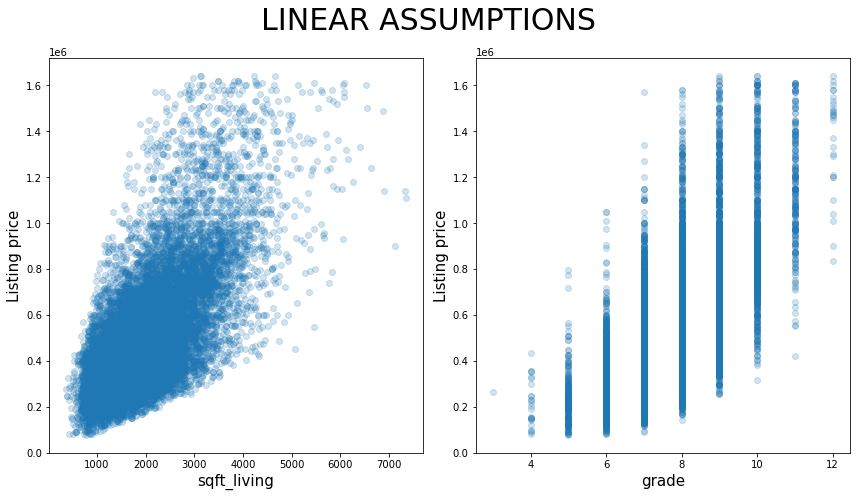

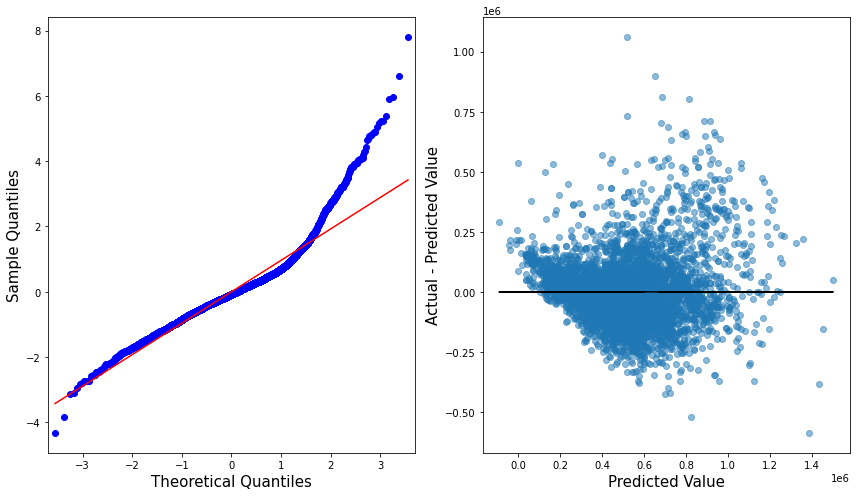

In [12]:
great_formula = good_formula + ['grade']
model_and_assume(great_formula)

### *Interpreting the Great * and Final * model*

Great model has an R-squared of .723. Square feet living, District, and Grade explains 72.3% of the variance in price. This is our first model which crosses the .7 R-squared threshold. The inclusion of Grade raised our R-squared from .68 to .72, for an increase of .04. Our great model definitely follows the linearity assumption, given that Districts are linear by definition, and Grade is also linear. The distribution of errors is unfortunately skewed right. Great model has low multicollinearity in general, with all VIF below 5 except for District_SEATTLE at 7. It passes the homoscedasticity test.

### Awesome Model: sqft_living, school districts, grade, year built

Awesome model includes square feet living, school districts, grade, and year built as predictors.

Model Score: 0.7387106369431495
Train RMSE: 132161.5994675322
Test RMSE: 131147.5984287356


                             OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.742
Model:                            OLS   Adj. R-squared:                  0.742
Method:                 Least Squares   F-statistic:                     2184.
Date:                Tue, 12 Oct 2021   Prob (F-statistic):               0.00
Time:                        23:01:48   Log-Likelihood:            -2.1084e+05
No. Observations:               15960   AIC:                         4.217e+05
Df Residuals:                   15938   BIC:                         4.219e+05
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------

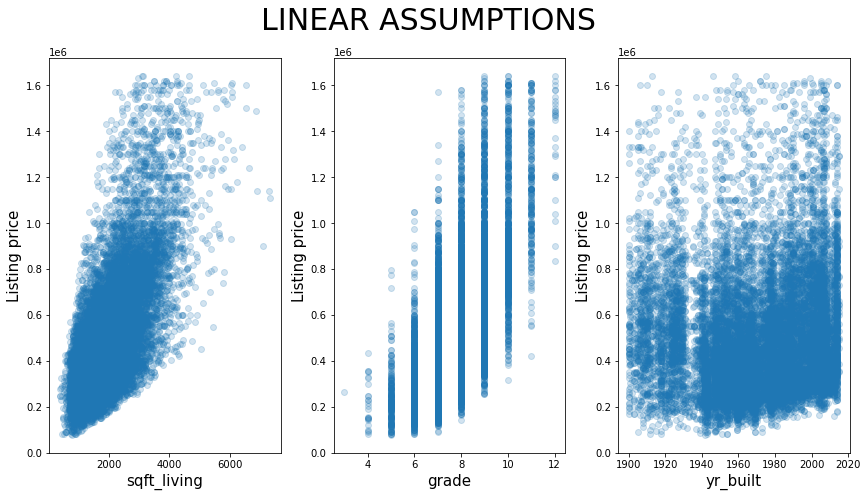

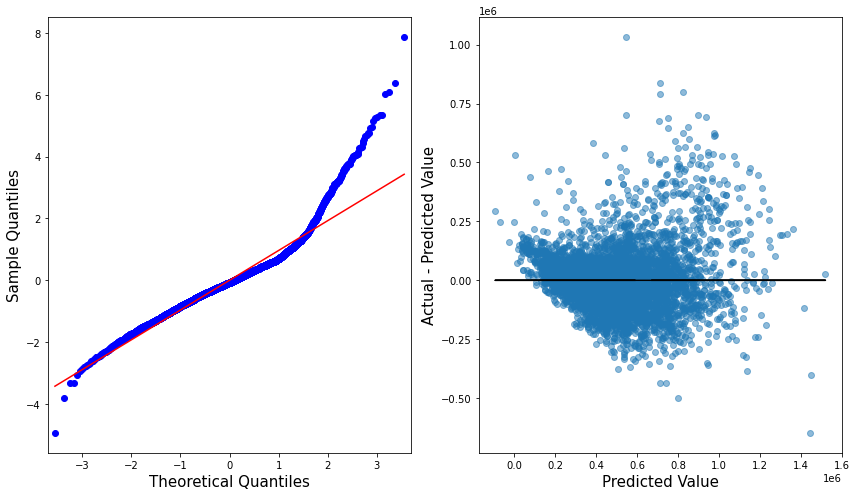

In [13]:
awesome_formula = great_formula + ['yr_built']
model_and_assume(awesome_formula)

### *Interpreting the Awesome model*

Awesome model has an R-squared of .742. Building on Great model, adding yr_built explains 74.2% of the variance in price. The inclusion of yr_built raised our R-squared from .72 to .74, for an increase of .02. 

Unfortunately, we believe we have reached the point of dimishing returns.

Our awesome model mostly follow the linearity assumption, but the linearity of yr_built is vague. The distribution of errors is skewed right. Good model has low multicollinearity in general, with all VIF below 5 except for District_SEATTLE at 7. It passes the homoscedasticity test.

### Amazing Model: sqft_living, school districts, grade, year built, view

Amazing model includes square feet living, school districts, grade, year built, and view as predictors.
This makes for a total of 5 predictors.

Model Score: 0.7541922832164802
Train RMSE: 128555.8861656814
Test RMSE: 127202.96471599228


                             OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.756
Model:                            OLS   Adj. R-squared:                  0.756
Method:                 Least Squares   F-statistic:                     2244.
Date:                Tue, 12 Oct 2021   Prob (F-statistic):               0.00
Time:                        23:01:51   Log-Likelihood:            -2.1040e+05
No. Observations:               15960   AIC:                         4.208e+05
Df Residuals:                   15937   BIC:                         4.210e+05
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------

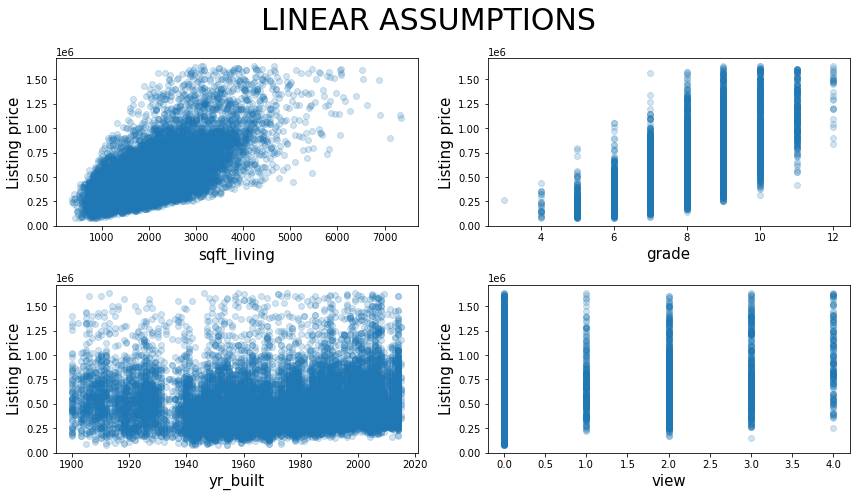

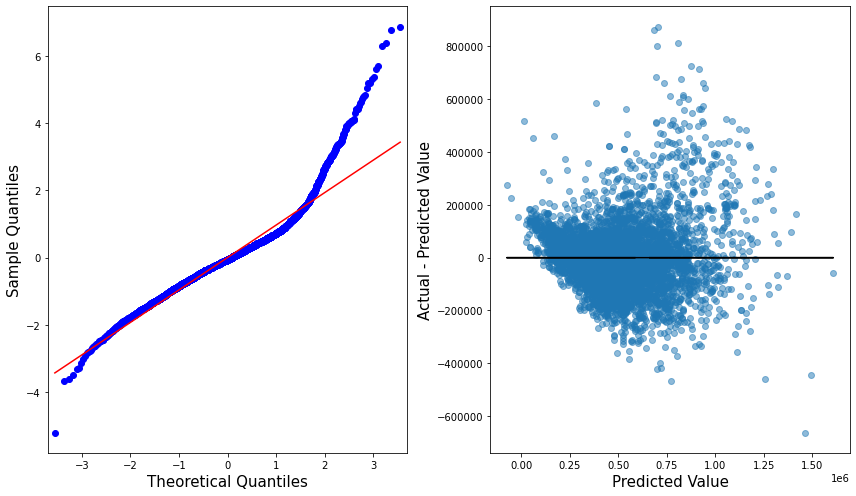

In [14]:
amazing_formula = awesome_formula + ['view']
model_and_assume(amazing_formula)

### *Interpreting the model*

Amazing model has an R-squared of .756. This is the highest R-squared value we were able to reach. This was built by using square feet living, school district, grade, year built, and view. The inclusion of view raised our R-squared from .742 to .756, for an increase of .14. Our amazing model has a couple predictors that are sketchy with the linearity assumption. Those variables are view and yr_built. This is part of the reason we decided not to use amazing model or awesome model as our final model. The distribution of errors is skewed right. Amazing model has low multicollinearity in general, with all VIF below 5 except for District_SEATTLE at 7. It passes the homoscedasticity test.

### Touching on School Districts

Since school districts is a more complex variable, we wanted to take some time to explain it. It was originally one column with 18 categores. We created dummy variables in order to model it. The result of that is 18 columns. Here, we have modeled all the districts by themselves in an OLS. We have taken data from the amazing train set for this OLS.

In [15]:
school_formula = df.iloc[:,6:].columns
model_and_assume(school_formula, final=True)


Model Score: 0.31457225854707493
Train RMSE: 214409.61406730535
Test RMSE: 212412.62010185592


                             OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.321
Model:                            OLS   Adj. R-squared:                  0.320
Method:                 Least Squares   F-statistic:                     419.2
Date:                Tue, 12 Oct 2021   Prob (F-statistic):               0.00
Time:                        23:01:54   Log-Likelihood:            -2.1857e+05
No. Observations:               15960   AIC:                         4.372e+05
Df Residuals:                   15941   BIC:                         4.373e+05
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
------------------

## Regression Results - Great model

We decided to use Great Model as our Final model. This model did very well with 3 predictors. Those predictors are square feet living, school district, and grade. The reasoning for selecting Great Model even though some of the following models had higher R-squared values was because it was simple, yet understandable. The following models seemed to muddy the waters when it came to the linearity assumption. 

The Great Model is able to explain 72.3% of the variance in price of King County Home Sales in 2014-15 with just 3 predictors.
This is a good R-squared value as it is above the 70% threshold. The model had a Train RMSE of 137070.49516065692 and a Test RMSE of 136447.31048874996. These are very close to each other, meaning the fit of the model is not underfit or overfit.

The Great Model does a great job at helping our stakeholder, the real estate agency, understand the gist of what drives home prices in the King County area. More specifically, it gives invaluable information about which school district they should target for either top end or bottom end location values.

In [16]:
model_and_assume(great_formula, final=True)

Model Score: 0.7191683886908452
Train RMSE: 137070.49516065692
Test RMSE: 135963.54296969337


                             OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.723
Model:                            OLS   Adj. R-squared:                  0.722
Method:                 Least Squares   F-statistic:                     2076.
Date:                Tue, 12 Oct 2021   Prob (F-statistic):               0.00
Time:                        23:01:54   Log-Likelihood:            -2.1143e+05
No. Observations:               15960   AIC:                         4.229e+05
Df Residuals:                   15939   BIC:                         4.231e+05
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------

## Conclusion

Our model showed us that the most important predictors to look at in a home are going to be square feet living, school district, and building grade. To relate this back to our stakeholder, we want to inform the real estate agency to focus on these elements in their deals. We can also help them by allowing them to plot different values in our model and giving them a rough valuation based on these variables.

Our model separates each home into 3 basic elements that contribute to value:
1. Home size & usable space (sqft_living)
2. Location (school district)
3. Upgrades, amenities, & design elements (grade)

To improve our model in the future, we could bin house sales by neighborhood. We could then compare home sales within individual neighborhood and model what features accounted for the discrepancies in sales price. This would give us a more detailed look at what features distinguish home valuations. This would also help the stakeholder with their offers and listings in a more detailed and refined level. More data would also be very useful. Another thing we could improve on is using more location metrics. The location metrics we would want to add include proximity to shopping, amenities, entertainment, recreation, airports, parks, schools, landmarks, tourist attractions, and employment opportunities. 